In [4]:
from ay_torch import *
import os
%matplotlib widget

In [13]:

'''
To download the dataset:
$ wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data_downloaded/
$ unzip data_downloaded/hymenoptera_data.zip -d data_downloaded/
'''
class AntBeeDataset(torch.utils.data.Dataset):
  classes= ['ants', 'bees']
  def __init__(self, root='data_downloaded/hymenoptera_data/', transform=None, train=True):
    self.transform= transform
    self.image_paths= []
    self.labels= []
    self.root= root
    self.MakePathLabelList(train)

  def MakePathLabelList(self, train):
    dir_train= 'train' if train else 'val'
    image_paths__labels= [
        (os.path.join(self.root, dir_train, cls, filename), label)
        for label,cls in enumerate(self.classes)
        for filename in os.listdir(os.path.join(self.root, dir_train, cls)) ]
    self.image_paths= [image_path for image_path,label in image_paths__labels]
    self.labels= [label for image_path,label in image_paths__labels]

  def __getitem__(self, index):
    with open(self.image_paths[index],'rb') as f:
      img= PILImage.open(f)
      img= img.convert('RGB')
    img= img if self.transform is None else self.transform(img)
    return img, self.labels[index]

  def __len__(self):
    return len(self.image_paths)

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor()
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [14]:
dset_train= AntBeeDataset(transform=GetDataTransforms('train'), train=True)
dset_test= AntBeeDataset(transform=GetDataTransforms('eval'), train=False)

#NOTE: Adjust the batch size.
n_batch= 10
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [15]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 245
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 0 ants
dset_train[0][0] value range: tensor(0.0078) tensor(1.)
dset_test size: 153
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 0 ants
dset_test[0][0] value range: tensor(0.) tensor(1.)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
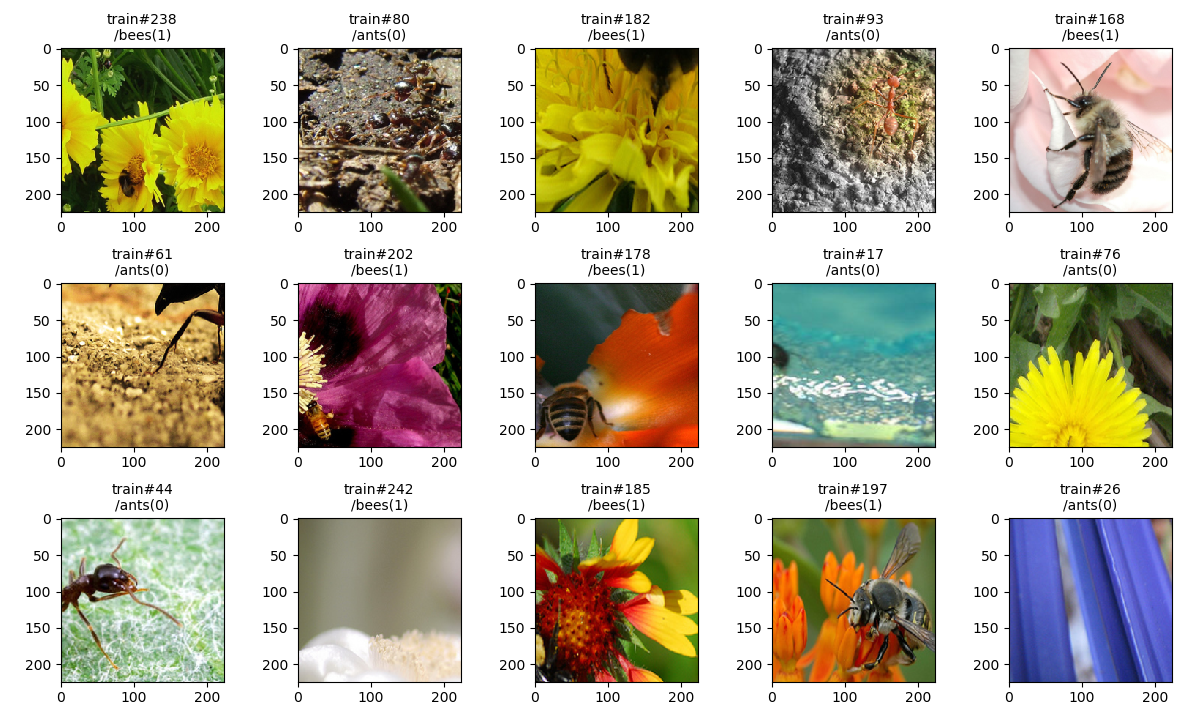

In [16]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [34]:
class TAlexNet(torch.nn.Module):
  def __init__(self, n_classes, img_shape, p_dropout=0.2):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    n_feat_out= self.net_features(torch.FloatTensor(*((1,)+img_shape))).view(1,-1).shape[1]
    self.net_classifier= torch.nn.Sequential(
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(n_feat_out, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(4096, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(4096, n_classes)
          )

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.net_classifier(x)

In [35]:
#Setup a neural network.
net= net= TAlexNet(n_classes=len(dset_train.classes), img_shape=dset_train[0][0].shape)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
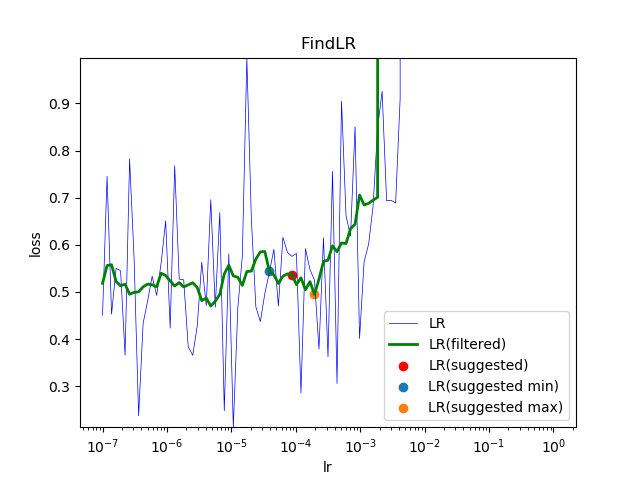

lr= 8.709635899560804e-05, lr_min=3.890451449942806e-05, lr_max=0.00019498445997580445


In [52]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
0.51074002	0.60595685	0.72916667	1.459046
0.53483152	0.61983296	0.68958333	1.401608
0.58690256	0.61969958	0.65625000	1.434429
0.56542670	0.67736052	0.71041667	1.451466
0.63012544	0.67532260	0.63125000	1.456654
0.59661885	0.60561613	0.71666667	1.429441
0.58074521	0.60302473	0.70833333	1.442676
0.54457877	0.63436047	0.72083333	1.392078
0.54629700	0.60560964	0.70833333	1.440137
0.50651583	0.60994357	0.70416667	1.448628
0.52992569	0.58370699	0.66458333	1.460170
0.47506932	0.60169346	0.73541667	1.403937
0.48289029	0.56834054	0.74791667	1.414949
0.45265863	0.55590377	0.74166667	1.424468
0.43446658	0.55747035	0.74166667	1.412511


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
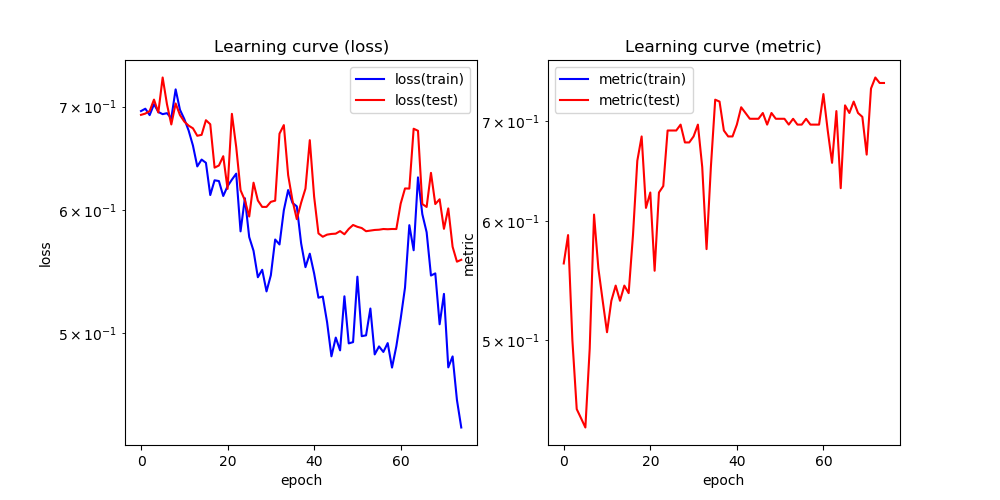

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
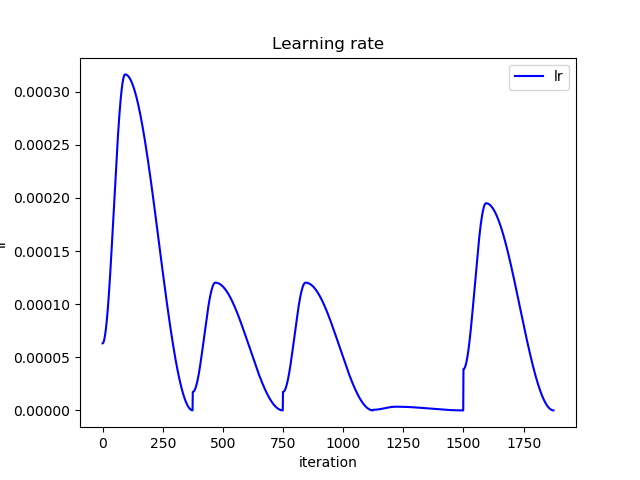

In [53]:
FitOneCycle(net, n_epoch=15, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
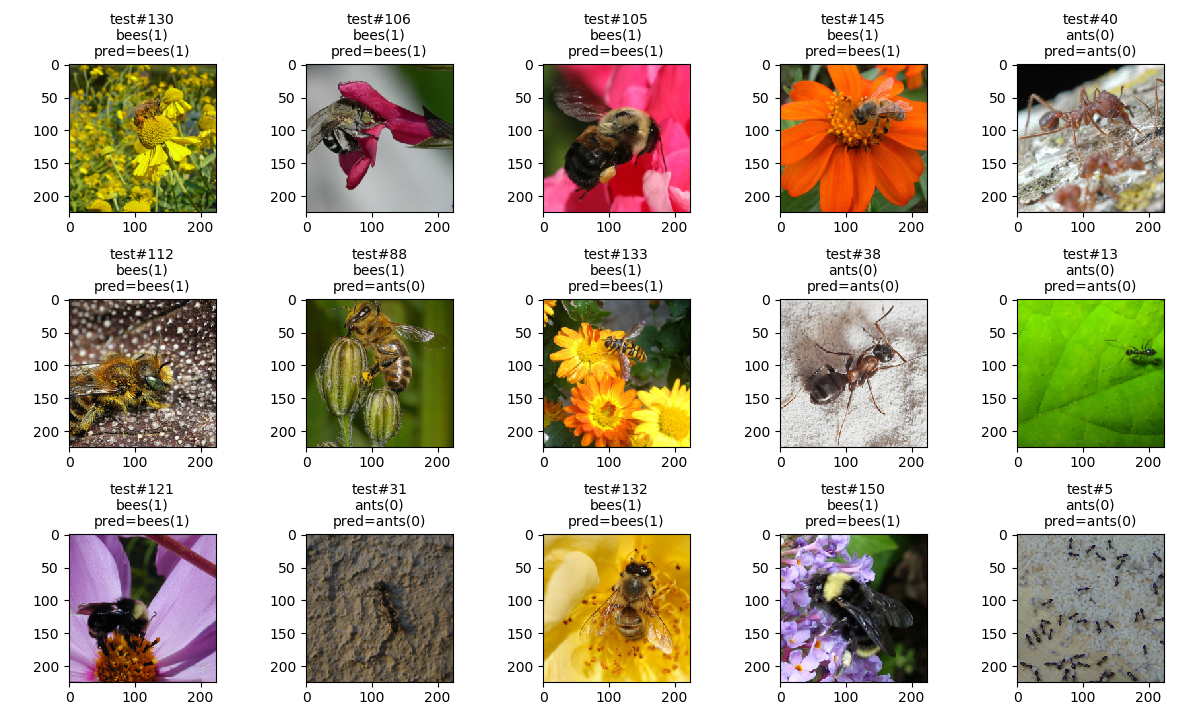

In [54]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)